# Importação e Instalação de Bibliotecas

In [ ]:
# Instalando Bibliotecas
!pip install music21
!apt-get install -y lilypond
!pip install pretty_midi
!pip install pyfluidsynth
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35 ghostscript
  libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libptexenc1
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lilypond-data
  lilypond-fonts lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x lilypond-doc
  python3-lxml poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc
The following NEW packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern

In [ ]:
# Importando bibliotecas

import numpy as np
import pandas as pd
import zipfile
import os
from music21 import instrument, note, chord, converter
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
%matplotlib inline
import sys
import warnings
from music21 import midi
import os
from collections import Counter
import tensorflow

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pretty_midi
from IPython.display import Audio
import fluidsynth

# Carregando e extraindo dados de treinamento

O conjunto de dados utilizados, consiste em arquivos MIDI de música clássica de piano, no nosso caso, de Mozart.

In [ ]:
# Caminho para o arquivo zip
caminho_arquivo_zip = '/content/archive.zip'

# Diretório de destino para extrair os arquivos
diretorio_destino = '/content'

# Nome da pasta dentro do arquivo zip que você deseja extrair
nome_pasta_desejada = 'mozart'

# Verifica se o diretório de destino existe, se não, cria-o
if not os.path.exists(diretorio_destino):
    os.makedirs(diretorio_destino)

# Abre o arquivo zip
with zipfile.ZipFile(caminho_arquivo_zip, 'r') as zip_ref:
    # Lista todos os arquivos no arquivo zip
    arquivos_zip = zip_ref.namelist()

    # Itera sobre todos os arquivos no arquivo zip
    for arquivo in arquivos_zip:
        # Verifica se o arquivo está dentro da pasta desejada
        if nome_pasta_desejada in arquivo:
            # Extrai o arquivo para o diretório de destino
            zip_ref.extract(arquivo, diretorio_destino)

A partir da lista com todas as músicas de Mozart como stream music21, foi criada uma função para extrair acordes e notas dos dados adicionando a uma lista, Corpus.

In [ ]:
diretorio_destino = '/content/mozart'

# Carrega os arquivos MIDI de Mozart
all_midis = []
for i in os.listdir(diretorio_destino):
    if i.endswith(".mid"):
        tr = os.path.join(diretorio_destino, i)
        midi = converter.parse(tr)
        all_midis.append(midi)

# Pré-processamento dos dados

Utilizando o stream music21 mencionado anteriormente, a função abaixo fará a extração das notas e acordes de piano do conjunto de dados. Em seguida, essas notas serão utilizadas para gerar uma composição musical, formando uma série de notas que refletem o estilo do artista em questão, no caso, Mozart.

In [ ]:
# Função para extrair as notas musicais
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

In [ ]:
# Adicionado a lista de notas na variável Corpus
Corpus = extract_notes(all_midis)

# Quantidade total de notas
print(len(Corpus))

55802


Agora a lista Corrpus armazena cada nota musical como uma string, que representa uma corda.

In [ ]:
# Vizualizando algumas notas
print(Corpus[:20])

['E5', 'C3', '5.7', 'C5', 'E3', '11.2', 'G3', '11.2', 'C4', 'F5', '0.4', 'C3', '11.2', 'G3', 'G2', 'E5', 'C3', '5.7', 'C5', 'E3']


A função a seguir serve para a vizualização das notas atráves de uma partitura, que consiste na vizualização das notas, ritmo e melodia da música.

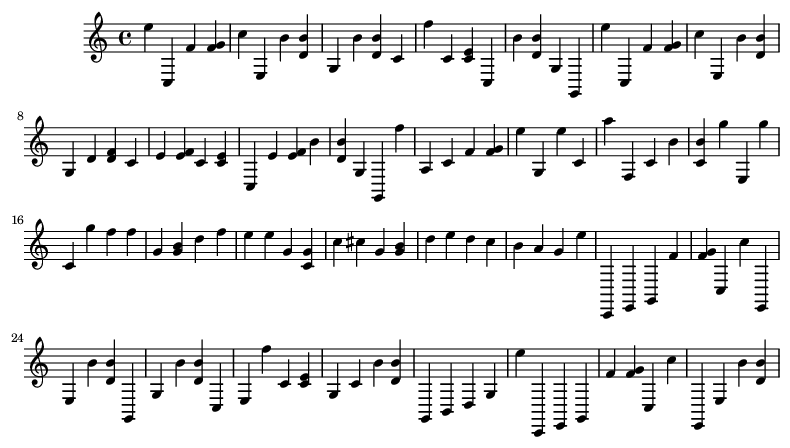

In [ ]:
# Função para vizualizar as notas
def show(music):
    display(Image(str(music.write("lily.png"))))

def chords_n_notes(Snippet):

    Melody = []
    offset = 0 # Contador
    for i in Snippet:
        # Verifica se é um acorde
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") # Separando as notas no acorde
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # Aumenta o deslocamento a cada iteração para que as notas não se acumulem
        offset += 1

    Melody_midi = stream.Stream(Melody)
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)

Com base na partitura foi gerado um audio para poder ouvir a música.

In [ ]:
def save_midi_as_audio(melody, output_file):
    # Salva a partitura como um arquivo MIDI temporário
    midi_file = melody.write('midi', fp=output_file + ".mid")

    # Convertendo o arquivo MIDI em um arquivo WAV
    os.system("timidity {} -Ow -o {}.mid".format(midi_file, output_file))
    print("Áudio salvo como {}.mid".format(output_file))

# Salvar a partitura como áudio
save_midi_as_audio(Melody_Snippet, "output_audio")

Áudio salvo como output_audio.mid


Partindo para uma análise mais detalhada das notas, foi observado que algumas notas não condiziam com uma nota musical real, então foram removidas com base na quantidade de repetições.

In [ ]:
# Criando um dicionário de contagem
count_num = Counter(Corpus)

# Quantidade total de notas únicas
print(len(count_num))

229


In [ ]:
# Obtendo uma lista de acordes estranhos
stranger_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 20:
        m =  key
        stranger_note.append(m)

# Quantidade de acordes estranhos
print(len(stranger_note))

94


In [ ]:
# Obtendo uma lista de acordes raros
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)

# Quantidade de acordes raros
print(len(rare_note))

145


In [ ]:
# Removendo notas estranhas
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

# Quantidade de notas após a remoção das notas estranhas
print(len(Corpus))

53135


Com a ajuda da biblioteca music1, que contêm frequência, comprimento de onda, duração e outras características das notas, junto a lista Corpus que possue o nome das respectivas notas musicais, será criado um dicionário para mapear as notas e seus índices para passar para a Rede Neural.

In [ ]:
# Armazenando todos os caracteres únicos presentes no corpus para criar um dic de mapeamento
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) # Tamanho do corpus
L_symb = len(symb) # Tamanho total de caracteres únicos

# Construindo dicionário para acessar o vocabulário a partir de índices (vice-versa)
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print(f"Quantidade total de caracteres: {L_corpus}")
print(f"Quantidade de caracteres únicos: {L_symb}")

In [ ]:
# Dividindo o Corpus em tamanho igual de strings e destino de saída
length = 40
features = []
targets = []

for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])

# Quantidade total de sequências do Corpus
L_datapoints = len(targets)
print(L_datapoints)

53095


# Treinamento



X é o conjunto de dados de entrada, uma matriz que contém as sequências de notas musicais, onde cada sequência é representada como uma lista de números inteiros mapeados a partir das notas e acordes no Corpus.

y é o conjunto de dados de saída, uma matriz codificada de forma one-hot (ou seja, cada classe é representada como um vetor binário onde um único bit é '1' e todos os outros são '0').

In [ ]:
# reshape X e normalizar
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)

# Codificação da variável de saída
y = tensorflow.keras.utils.to_categorical(targets)

Para ser possível fazer a reprodução da divisão dos dados, foi criada uma semente de valor 42.

In [ ]:
# Separando os dados de treino e um subconjunto de dados para ser usado como semente
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Inicializando modelo LSTM
model = Sequential()

# Adicionando as camadas
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())  # Adicionando Batch Normalization
model.add(LSTM(128))
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))

# Compilando o modelo para o treinamento
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

O modelo de rede neural usado foi recorrente (RNN) do tipo LSTM (Long Short-Term Memory), que é frequentemente utilizado em tarefas de sequência, como previsão de séries temporais, tradução automática e geração de texto, incluindo música.

In [ ]:
# Sumário do modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 40, 128)           0         
                                                                 
 batch_normalization (Batch  (None, 40, 128)           512       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [ ]:
# Treinando o modelo
history = model.fit(X_train, y_train, batch_size=256, epochs=80)

Vizualizando a curva de aprendizado do modelo

[Text(0.5, 0, 'Epochs')]

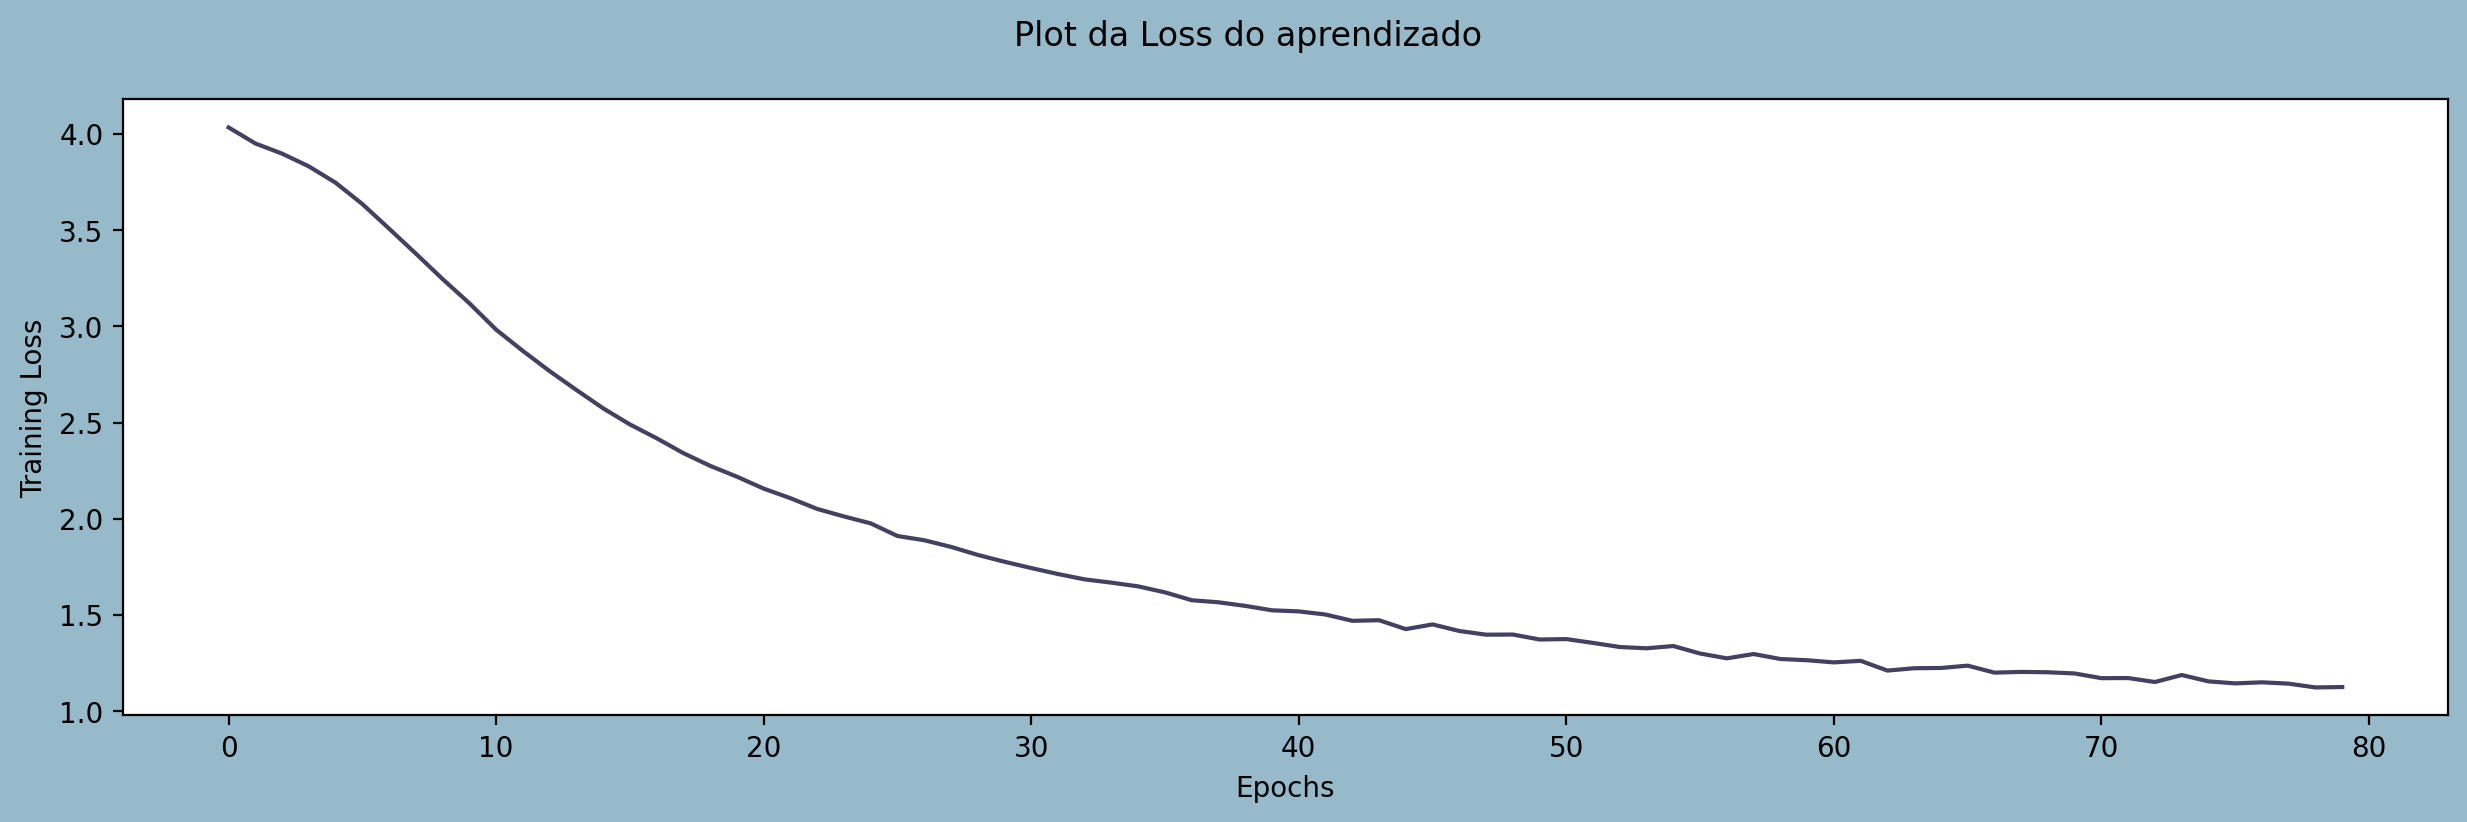

In [ ]:
# Plotando o aprendizado
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Plot da Loss do aprendizado")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

# Resultados



Com base no treinamento, é possível determinar uma quantidade de notas desejadas e fazer o modelo gerar novas músicas de Mozart como se fosse o próprio.

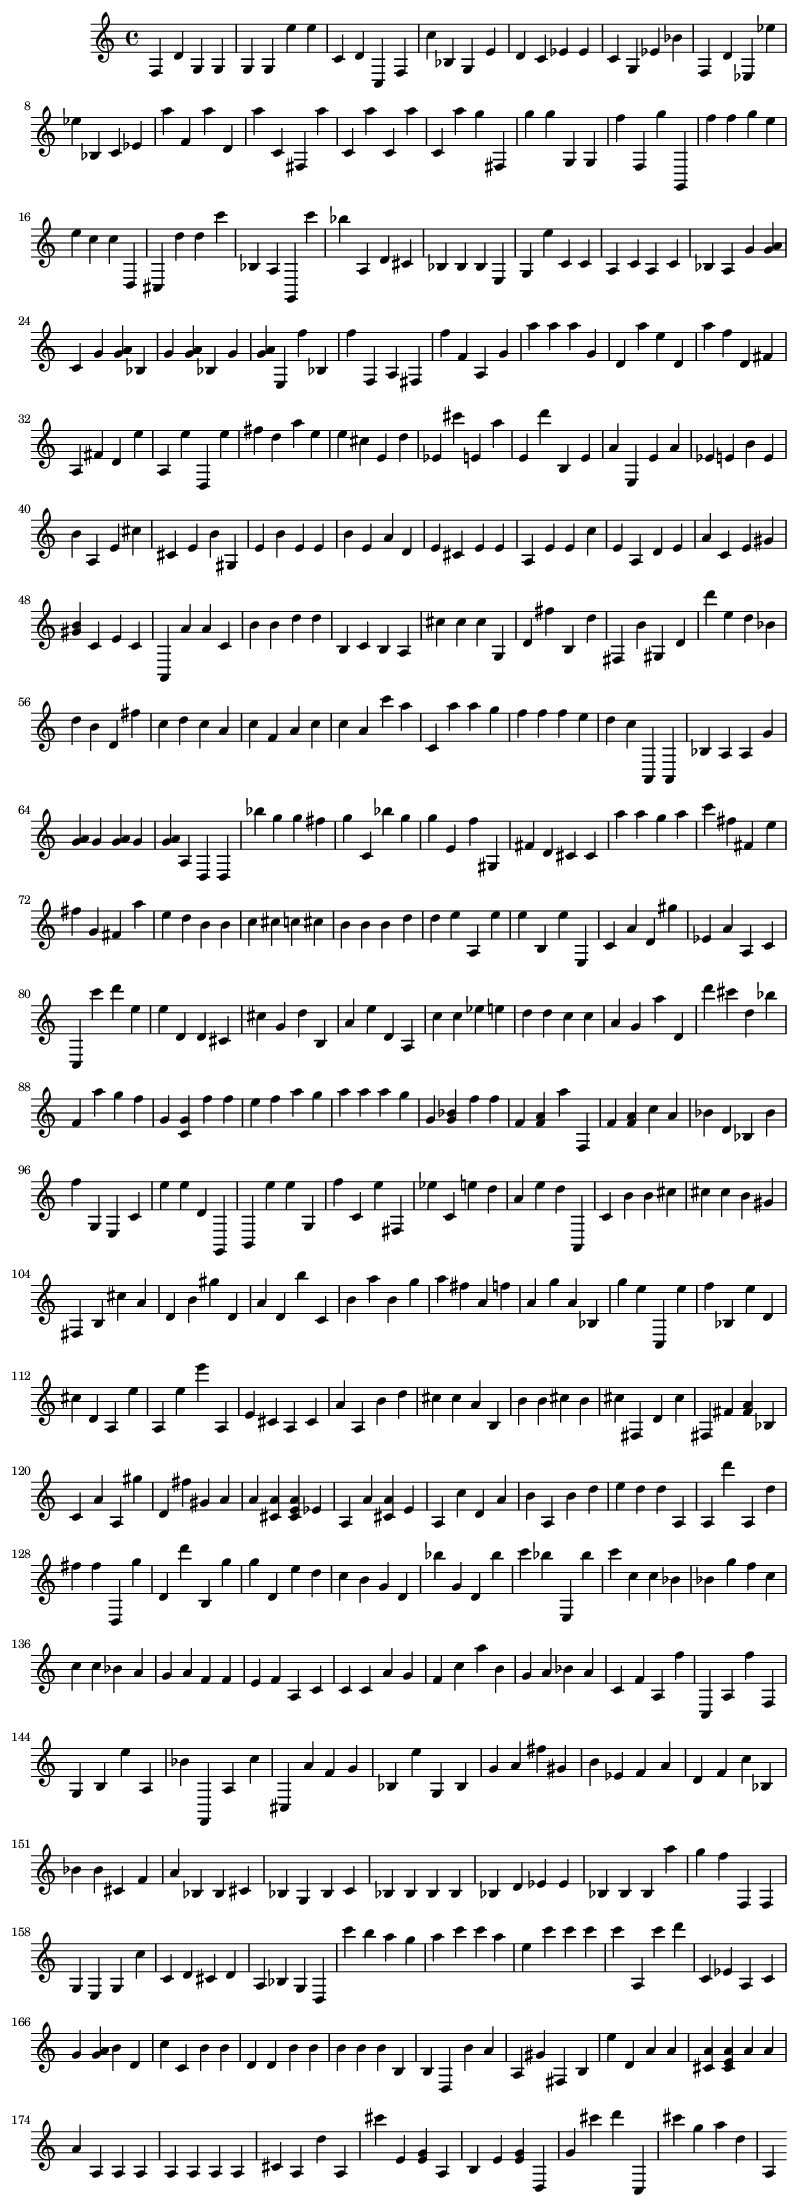

In [ ]:
# Gerando uma nova partitura e audio midi
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    # Agora temos a música em forma ou uma lista de acordes e notas e queremos que seja um arquivo midi
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)
    return Music,Melody_midi


# Obtendo as notas e melodia criadas pelo modelo
Music_notes, Melody = Malody_Generator(700)
show(Melody)

In [ ]:
save_midi_as_audio(Melody, "output_generation")

Áudio salvo como output_generation.mid


In [ ]:
#Tocando o audio gerado

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  _SAMPLING_RATE = 16000
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return Audio(waveform_short, rate=_SAMPLING_RATE)

def playAudio(path):
  pm = pretty_midi.PrettyMIDI(path)
  return display_audio(pm)

In [ ]:
pathAudio = 'output_generation.mid'
playAudio(pathAudio)

## Referências
---
https://www.kaggle.com/code/julyannasilva/music-generation-lstm/edit

